<a href="https://colab.research.google.com/github/AryanShr/offenSec/blob/main/AdversarialFeatureVectureGenerator/MalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import List, Tuple
from enum import Enum
from typing import Union
import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
import warnings
from pathlib import Path
import pickle
from rich.progress import track
from tqdm import tqdm
import os
import datetime
import matplotlib.pyplot as plt


In [ ]:
tc = torch.cuda if torch.cuda.is_available() else torch
TensorTuple = Tuple[torch.Tensor, torch.Tensor]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
    def __init__(self, M: int, Z: int, hidden_size: List[int], g: nn.Module):
        """Generator Constructor

        :param M: Dimension of the feature vector \p m
        :param Z: Dimension of the noise vector \p z
        :param hidden_size: Width of the hidden layer(s)
        :param g: Activation function
        """
        super().__init__()
        self._Z = Z
        # Build the feed forward net
        self._layers, dim = nn.ModuleList(), [M + self._Z] + hidden_size
        for d_in, d_out in zip(dim[:-1], dim[1:]):
            self._layers.append(nn.Sequential(nn.Linear(d_in, d_out), g))

        # Last layer is always sigmoid
        layer = nn.Sequential(nn.Linear(dim[-1], M), nn.Sigmoid())
        self._layers.append(layer)
    def forward(self, m: torch.Tensor, z: torch.Tensor = None) -> TensorTuple:
        """
        Forward pass through the generator.  Automatically generates the noise vector \p z that
        is coupled with \p m.

        :param m: Input vector :math:`m`
        :param z: Noise vector :math:`z`.  If no random vector is specified, the random vector is
                  generated within this function call via a call to \p torch.rand
        :return: Tuple of (:math:`m'`, :math:`G_{\theta_{g}}`), i.e., the output tensor with the
                 feature predictions as well as the smoothed prediction that can be used for
                 back-propagation.
        """
        if z is None:
            num_ele = m.shape[0]
            z = tc.FloatTensor(num_ele, self._Z).to(device)
            z.uniform_(0, 1)
        # Concatenation of m and z
        o = torch.cat((m, z), dim=1).to(device)
        for layer in self._layers:
            o = layer(o)
        g_theta = torch.max(m, o)  # Ensure binary bits only set positive

        # m_prime is binarized version of g_sigma
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            threshold = tc.FloatTensor([0.5])
        m_prime = (g_theta > threshold).float()
        return m_prime, g_theta

In [ ]:
class Discriminator(nn.Module):
    """ MalGAN discriminator (substitute detector).  Simple feed forward network. """

    def __init__(self, M: int, hidden_size: List[int], g: nn.Module):
        super().__init__()

        # Build the feed forward layers.
        self._layers = nn.ModuleList()
        for in_w, out_w in zip([M] + hidden_size[:-1], hidden_size):
            layer = nn.Sequential(nn.Linear(in_w, out_w), g)
            self._layers.append(layer)

        layer = nn.Sequential(nn.Linear(hidden_size[-1], 1), nn.Sigmoid())
        self._layers.append(layer)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        d_theta = X
        for layer in self._layers:
            d_theta = layer(d_theta)
        # return d_theta
        err = 1e-7
        return torch.clamp(d_theta, err, 1. - err).view(-1)

In [ ]:
TorchOrNumpy = Union[np.ndarray, torch.Tensor]


In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
class BlackBoxDetector:
    """
    Black box detector that intends to mimic an antivirus/anti-Malware program that detects whether
    a specific program is either malware or benign.
    """
    class Type(Enum):
        DecisionTree = DecisionTreeClassifier()
        LogisticRegression = LogisticRegression(solver='lbfgs', max_iter=int(1e6))
        MultiLayerPerceptron = MLPClassifier()
        RandomForest = RandomForestClassifier(n_estimators=100)
        SVM = SVC(gamma="auto", probability=True)

        @staticmethod
        def names():
            r""" Builds the list of all enum names """
            return [c.name for c in BlackBoxDetector.Type]

        @staticmethod
        def get_from_name(name):
            for c in BlackBoxDetector.Type:
                if c.name == name:
                    return c
            raise ValueError("Unknown enum \"%s\" for class \"%s\"", name, __class__.name)

    def __init__(self, learner_type: List['BlackBoxDetector.Type']):
        self.type = learner_type
        # self._model = sklearn.clone(self.type.value)

        self._models = [(type_.name, sklearn.clone(type_.value)) for type_ in self.type]
        self._model = VotingClassifier(estimators=self._models, voting='soft')

        self.training = True

    def fit(self, X: TorchOrNumpy, y: TorchOrNumpy):
        if isinstance(X, torch.Tensor):
            X = X.detach().numpy()
        if isinstance(y, torch.Tensor):
            y = y.numpy()
        self._model.fit(X, y)
        self.training = False

    def predict(self, X: TorchOrNumpy) -> torch.tensor:
        if self.training:
            raise ValueError("Detector does not appear to be trained but trying to predict")
        if torch.cuda.is_available():
            X = X.cpu()
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        y = torch.from_numpy(self._model.predict(X)).float()
        return y.cuda() if torch.cuda.is_available() else y

In [ ]:
class Label(Enum):
  """ Label value assigned to malware and benign examples """
  Malware = 1
  Benign = 0

In [ ]:
MALWARE_BATCH_SIZE = 32

SAVED_MODEL_DIR = Path("saved_models")

VALIDATION_SPLIT = 0.2

tensorboard = None

In [ ]:
class MalwareDataset(Dataset):
    """
    Encapsulates a malware dataset.  All elements in the dataset will be either malware or benign
    """
    def __init__(self, x: Union[np.ndarray, torch.Tensor], y):
        super().__init__()

        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y

    def __len__(self):
        return self.x.shape[0]

    @property
    def num_features(self):
        r""" Number of features in the dataset """
        return self.x.shape[1]

In [ ]:
def load_dataset(file_path: Union[str, Path], y: int) -> MalwareDataset:
    file_ext = Path(file_path).suffix
    if file_ext in {".npy", ".npz"}:
        data = np.load(file_path)
        # DEBUG
        print(data.view())

    elif file_ext in {".pt", ".pth"}:
        data = torch.load(str(file_path))
    elif file_ext == ".pk":
        with open(str(file_path), "rb") as f_in:
            data = pickle.load(f_in)
    else:
        raise ValueError("Unknown file extension.  Cannot determine how to import")
    return MalwareDataset(x=data, y=y)


In [ ]:
malware_features = Path("/content/drive/MyDrive/Feature_Vector/malware_pe_files_section_feature_set.pk")
benign_features = Path("/content/drive/MyDrive/Feature_Vector/benign_pe_files_section_feature_set.pk")
output_filename = "adversarial_section_set.pk"

In [ ]:
malware = load_dataset(str(malware_features), 1)
malware

In [ ]:
malware[:][0].shape[0]

6279

In [ ]:
malware[-1]

(tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [ ]:
malware.num_features

317

In [ ]:
benign = load_dataset(str(benign_features), 0)
benign

In [ ]:
benign.num_features

317

In [ ]:
class _DataGroup:
    r"""Encapsulates either PyTorch DataLoaders or Datasets.  This class is intended only for internal use by MalGAN."""
    def __init__(self, train: MalwareDataset, valid: MalwareDataset, test: MalwareDataset):
        self.train = train
        self.valid = valid
        self.test = test
        self.is_loaders = False

    def build_loader(self, batch_size: int = 0):
        r""" Constructs loaders from the datasets :param batch_size: Batch size for training """
        self.train = DataLoader(self.train, batch_size=batch_size, shuffle=True, pin_memory=True)
        if self.valid:
            self.valid = DataLoader(self.valid, batch_size=batch_size, pin_memory=True)
        self.test = DataLoader(self.test, batch_size=batch_size, pin_memory=True)
        self.is_loaders = True

In [ ]:
g_hidden= nn.LeakyReLU

In [ ]:
if not isinstance(g_hidden, nn.Module):
    g_hidden = g_hidden()
g = g_hidden

In [ ]:
bb = BlackBoxDetector([BlackBoxDetector.Type.RandomForest])

In [ ]:
# bb = BlackBoxDetector([BlackBoxDetector.Type.DecisionTree, BlackBoxDetector.Type.LogisticRegression, BlackBoxDetector.Type.RandomForest, BlackBoxDetector.Type.MultiLayerPerceptron, BlackBoxDetector.Type.SVM ])

In [ ]:
gen = Generator(M=malware.num_features, Z=10, hidden_size=[241,482,241], g=g).to(device)

In [ ]:
discrim = Discriminator(M=malware.num_features, hidden_size=[241,482,482,241], g=g).to(device)

In [ ]:
def split_train_valid_test(dataset: Dataset, is_benign: bool):
  """Helper function to partition into test, train, and validation subsets"""
  valid_len = 0 if is_benign else int(VALIDATION_SPLIT * len(dataset))
  test_len = int(0.3 * len(dataset))

  # Order must be train, validation, test
  lengths = [len(dataset) - valid_len - test_len, valid_len, test_len]
  return _DataGroup(*torch.utils.data.random_split(dataset, lengths))

In [ ]:
mal_data = split_train_valid_test(malware, is_benign=False)
ben_data = split_train_valid_test(benign, is_benign=True)
mal_data, ben_data

(<__main__._DataGroup at 0x7a0c2ffbe6b0>,
 <__main__._DataGroup at 0x7a0c2ffbc1f0>)

In [ ]:
mal_data.train

In [ ]:
mal_data.test

In [ ]:
cnt = 0
for a,b in mal_data.test:
  cnt+=1

cnt

59

In [ ]:
m_orig = []
for m, _ in mal_data.test:
  m_orig.append(m);

pickle.dump(m_orig, open(os.path.join('/content/drive/MyDrive/Output/', 'Original.pk'), 'wb'))
# len(m_orig[0][0])

In [ ]:
def extract_x(ds: Subset) -> torch.Tensor:
  # noinspection PyUnresolvedReferences
  x = ds.dataset.x[ds.indices]
  return x.cpu() if torch.cuda.is_available() else x

In [ ]:
mal_x = extract_x(mal_data.train)
ben_x = extract_x(ben_data.train)

In [ ]:
merge_data = torch.cat((mal_x,ben_x))
merge_data

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.]])

In [ ]:
merge_data.shape

torch.Size([5960, 317])

In [ ]:
merged_y = torch.cat((torch.full((len(mal_data.train),), 1), torch.full((len(ben_data.train),), 0)))
merged_y

tensor([1, 1, 1,  ..., 0, 0, 0])

In [ ]:
merged_y.shape

torch.Size([5960])

In [ ]:
bb.fit(merge_data,merged_y)

In [ ]:
# ben_test = extract_x(ben_data.test)

In [ ]:
# ben_test.shape

In [ ]:
# bb.predict(ben_test[:20])

In [ ]:
mal_data.build_loader(MALWARE_BATCH_SIZE)

In [ ]:
ben_bs_frac = len(benign) / len(malware)
ben_bs_frac

0.6411849020544673

In [ ]:
ben_data.build_loader(int(ben_bs_frac * MALWARE_BATCH_SIZE))

In [ ]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import tensorboardX

In [ ]:
tensorboard = tensorboardX.SummaryWriter()
tensorboard

In [ ]:
Z = 100  #Noise dimension

In [ ]:
class _CompGraph(nn.Module):
    r""" Helper class used to visualize the computation graph """
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = torch.zeros(x.shape[0], Z)
        m_prime, _ = gen.forward(x, z)
        return discrim.forward(m_prime)

In [ ]:
# torch.zeros(1, malware.num_features,requires_grad=True).detach()

In [ ]:
# tensorboard.add_graph(_CompGraph(), torch.zeros(1, malware.num_features))

In [ ]:
d_optimizer = torch.optim.Adam(discrim.parameters(), lr=1e-5)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [ ]:
tpr_values= []

In [ ]:
def _fit_epoch(epoch_num: int, g_optim: torch.optim.Optimizer, d_optim: torch.optim.Optimizer) -> TensorTuple:
        """
        Trains a single entire epoch

        :param epoch_num: Epoch number
        :param g_optim: Generator optimizer
        :param d_optim: Discriminator optimizer
        :return: Average training loss
        """
        tot_l_g = tot_l_d = 0
        num_batch = min(len(mal_data.train), len(ben_data.train))

        print(f"Starting training epoch #{epoch_num} with {num_batch} batches")
        desc = f"Epoch {epoch_num} Progress"
        batch_generator = merged_data = zip(mal_data.train, ben_data.train)
        for (m, _), (b, _) in batch_generator:
            if torch.cuda.is_available():
                m, b = m.to(device), b.to(device)
            m_prime, g_theta = gen.forward(m)
            l_g = -discrim.forward(g_theta).log().mean()
            g_optim.zero_grad()
            l_g.backward()
            # torch.nn.utils.clip_grad_value_(l_g, 1)
            g_optim.step()
            tot_l_g += l_g

            # Update the discriminator
            for x in [m_prime, b]:
                x = x.to(device)
                d_tetha = discrim.forward(x)
                l_d = -(torch.where(bb.predict(x) == 1, d_tetha, 1 - d_tetha)).log().mean()
                d_optim.zero_grad()
                l_d.backward()
                # torch.nn.utils.clip_grad_value_(l_d, 1)
                d_optim.step()
                tot_l_d += l_d
        print(f"\t Completed training epoch #{epoch_num}")
        return tot_l_g / num_batch, tot_l_d / num_batch

In [ ]:
def _meas_loader_gen_loss(loader: DataLoader, gen = gen, discrim = discrim) -> float:
  """ Calculate the generator loss on malware dataset """
  loss = 0
  for m, true_labels in loader:
      if torch.cuda.is_available():
          m = m.cuda()
      _, g_theta = gen.forward(m)
      predictions = -discrim.forward(g_theta).log().mean()
      loss += predictions
  return loss / len(loader)

In [ ]:
num_epoch = 100

In [ ]:
best_epoch, best_loss = None, np.inf

In [ ]:
def _calculate_tpr_for_epoch(validation_loader, bb, discrim):
    tpr_values = []

    for batch, _ in validation_loader:
        with torch.no_grad():
            if torch.cuda.is_available():
                batch = batch.cuda()

            predictions = (discrim.forward(batch) < 0.5).float()
            targets = torch.where(bb.predict(batch) == 1, torch.tensor(1.0), torch.tensor(0.0))

            tp = torch.sum((predictions == 1) & (targets == 1)).item()
            fn = torch.sum((predictions == 0) & (targets == 1)).item()

            # Avoid division by zero
            if tp + fn == 0:
                tpr = 0.0
            else:
                tpr = tp / (tp + fn)

            tpr_values.append(tpr)

    avg_tpr = np.mean(tpr_values)
    print(f"\t TPR for Training set: {avg_tpr}")

    return avg_tpr


In [ ]:
for epoch_cnt in track(range(1, num_epoch + 1), description="Training GAN ...", transient=True):
    train_l_g, train_l_d = _fit_epoch(epoch_cnt,g_optimizer, d_optimizer)
    for block, loss in [("Generator", train_l_g), ("Discriminator", train_l_d)]:
        tensorboard.add_scalar('Train_%s_Loss' % block, loss, epoch_cnt)
        print(f"\t Epoch {epoch_cnt}: Avg Train {block} Loss: {loss}")
    valid_l_g= _meas_loader_gen_loss(mal_data.valid)
    tpr_values.append(_calculate_tpr_for_epoch(mal_data.train, bb, discrim))
    tensorboard.add_scalar('Validation_Generator_Loss', valid_l_g, epoch_cnt)
    if valid_l_g < best_loss:
        # _save(self._build_export_name(epoch_cnt))
        # if best_epoch is not None:
        #     self._delete_old_backup(best_epoch)
        best_epoch, best_loss = epoch_cnt, valid_l_g
        print(f"\t Epoch {best_epoch}: New best validation loss: {best_loss}\n")
    else:
        print(f"\t Epoch {epoch_cnt}: Avg Validation Generator Loss: {valid_l_g}\n")
print(f" Training complete. Best epoch is {best_epoch} with loss {best_loss}")
tensorboard.close()

Output()

Starting training epoch #1 with 99 batches

Completed training epoch #1

Epoch 1: Avg Train Generator Loss: 0.7536687850952148

Epoch 1: Avg Train Discriminator Loss: 1.2976995706558228

TPR for Training set: 1.0

Epoch 1: New best validation loss: 0.7987048625946045

Starting training epoch #2 with 99 batches

Completed training epoch #2

Epoch 2: Avg Train Generator Loss: 0.8187851309776306

Epoch 2: Avg Train Discriminator Loss: 1.278220534324646

TPR for Training set: 1.0

Epoch 2: New best validation loss: 0.7782891988754272

Starting training epoch #3 with 99 batches

Completed training epoch #3

Epoch 3: Avg Train Generator Loss: 0.7355986833572388

Epoch 3: Avg Train Discriminator Loss: 1.213609218597412

TPR for Training set: 1.0

Epoch 3: New best validation loss: 0.6818461418151855

Starting training epoch #4 with 99 batches

Completed training epoch #4

Epoch 4: Avg Train Generator Loss: 0.6248134970664978

Epoch 4: Avg Train Discriminator Loss: 0.9723497629165649

TPR for Training set: 1.0

Epoch 4: New best validation loss: 0.5270887613296509

Starting training epoch #5 with 99 batches

Completed training epoch #5

Epoch 5: Avg Train Generator Loss: 0.34257519245147705

Epoch 5: Avg Train Discriminator Loss: 0.6776151061058044

TPR for Training set: 1.0

Epoch 5: New best validation loss: 0.18697874248027802

Starting training epoch #6 with 99 batches

Completed training epoch #6

Epoch 6: Avg Train Generator Loss: 0.08002543449401855

Epoch 6: Avg Train Discriminator Loss: 0.33897560834884644

TPR for Training set: 1.0

Epoch 6: New best validation loss: 0.022561799734830856

Starting training epoch #7 with 99 batches

Completed training epoch #7

Epoch 7: Avg Train Generator Loss: 0.01127649936825037

Epoch 7: Avg Train Discriminator Loss: 0.2455490380525589

TPR for Training set: 1.0

Epoch 7: New best validation loss: 0.004946272354573011

Starting training epoch #8 with 99 batches

Completed training epoch #8

Epoch 8: Avg Train Generator Loss: 0.003232678398489952

Epoch 8: Avg Train Discriminator Loss: 0.23965001106262207

TPR for Training set: 1.0

Epoch 8: New best validation loss: 0.001942870207130909

Starting training epoch #9 with 99 batches

Completed training epoch #9

Epoch 9: Avg Train Generator Loss: 0.0013674817746505141

Epoch 9: Avg Train Discriminator Loss: 0.21952320635318756

TPR for Training set: 1.0

Epoch 9: New best validation loss: 0.0009961838368326426

Starting training epoch #10 with 99 batches

Completed training epoch #10

Epoch 10: Avg Train Generator Loss: 0.0007687367033213377

Epoch 10: Avg Train Discriminator Loss: 0.19963009655475616

TPR for Training set: 1.0

Epoch 10: New best validation loss: 0.0005982402944937348

Starting training epoch #11 with 99 batches

Completed training epoch #11

Epoch 11: Avg Train Generator Loss: 0.0004764535406138748

Epoch 11: Avg Train Discriminator Loss: 0.18449626863002777

TPR for Training set: 1.0

Epoch 11: New best validation loss: 0.00036092111258767545

Starting training epoch #12 with 99 batches

Completed training epoch #12

Epoch 12: Avg Train Generator Loss: 0.0002798668865580112

Epoch 12: Avg Train Discriminator Loss: 0.1803177297115326

TPR for Training set: 1.0

Epoch 12: New best validation loss: 0.0002036269725067541

Starting training epoch #13 with 99 batches

Completed training epoch #13

Epoch 13: Avg Train Generator Loss: 0.00015294560580514371

Epoch 13: Avg Train Discriminator Loss: 0.1518852710723877

TPR for Training set: 1.0

Epoch 13: New best validation loss: 0.0001062447699951008

Starting training epoch #14 with 99 batches

Completed training epoch #14

Epoch 14: Avg Train Generator Loss: 8.01451678853482e-05

Epoch 14: Avg Train Discriminator Loss: 0.12893365323543549

TPR for Training set: 1.0

Epoch 14: New best validation loss: 5.1574112148955464e-05

Starting training epoch #15 with 99 batches

Completed training epoch #15

Epoch 15: Avg Train Generator Loss: 3.527848093654029e-05

Epoch 15: Avg Train Discriminator Loss: 0.10663962364196777

TPR for Training set: 0.39781891495601174

Epoch 15: New best validation loss: 2.1330113668227568e-05

Starting training epoch #16 with 99 batches

Completed training epoch #16

Epoch 16: Avg Train Generator Loss: 1.4030496458872221e-05

Epoch 16: Avg Train Discriminator Loss: 0.08568044751882553

TPR for Training set: 0.34485921038340395

Epoch 16: New best validation loss: 9.398621841683052e-06

Starting training epoch #17 with 99 batches

Completed training epoch #17

Epoch 17: Avg Train Generator Loss: 5.922679520153906e-06

Epoch 17: Avg Train Discriminator Loss: 0.07252682000398636

TPR for Training set: 0.34447431302270015

Epoch 17: New best validation loss: 3.6763219668500824e-06

Starting training epoch #18 with 99 batches

Completed training epoch #18

Epoch 18: Avg Train Generator Loss: 2.367969727856689e-06

Epoch 18: Avg Train Discriminator Loss: 0.0634186789393425

TPR for Training set: 0.343893116369479

Epoch 18: New best validation loss: 1.4432446278078714e-06

Starting training epoch #19 with 99 batches

Completed training epoch #19

Epoch 19: Avg Train Generator Loss: 1.013090923152049e-06

Epoch 19: Avg Train Discriminator Loss: 0.05922975018620491

TPR for Training set: 0.34356400021722605

Epoch 19: New best validation loss: 4.7674407710474043e-07

Starting training epoch #20 with 99 batches

Completed training epoch #20

Epoch 20: Avg Train Generator Loss: 3.3181427738782077e-07

Epoch 20: Avg Train Discriminator Loss: 0.05227266624569893

TPR for Training set: 0.3438253502769632

Epoch 20: New best validation loss: 2.2957104306442488e-07

Starting training epoch #21 with 99 batches

Completed training epoch #21

Epoch 21: Avg Train Generator Loss: 1.276382448622826e-07

Epoch 21: Avg Train Discriminator Loss: 0.0473429411649704

TPR for Training set: 0.34399166395134145

Epoch 21: New best validation loss: 1.1920930376163597e-07

Starting training epoch #22 with 99 batches

Completed training epoch #22

Epoch 22: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 22: Avg Train Discriminator Loss: 0.04098503664135933

TPR for Training set: 0.34375407298794397

Epoch 22: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #23 with 99 batches

Completed training epoch #23

Epoch 23: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 23: Avg Train Discriminator Loss: 0.033043403178453445

TPR for Training set: 0.34569281524926687

Epoch 23: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #24 with 99 batches

Completed training epoch #24

Epoch 24: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 24: Avg Train Discriminator Loss: 0.032273780554533005

TPR for Training set: 0.2606909145215597

Epoch 24: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #25 with 99 batches

Completed training epoch #25

Epoch 25: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 25: Avg Train Discriminator Loss: 0.029575884342193604

TPR for Training set: 0.3433522048441403

Epoch 25: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #26 with 99 batches

Completed training epoch #26

Epoch 26: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 26: Avg Train Discriminator Loss: 0.02653801068663597

TPR for Training set: 0.25883906266970785

Epoch 26: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #27 with 99 batches

Completed training epoch #27

Epoch 27: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 27: Avg Train Discriminator Loss: 0.02510787546634674

TPR for Training set: 0.2518785603532544

Epoch 27: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #28 with 99 batches

Completed training epoch #28

Epoch 28: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 28: Avg Train Discriminator Loss: 0.020880669355392456

TPR for Training set: 0.24710752313644416

Epoch 28: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #29 with 99 batches

Completed training epoch #29

Epoch 29: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 29: Avg Train Discriminator Loss: 0.018789639696478844

TPR for Training set: 0.24865930813511455

Epoch 29: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #30 with 99 batches

Completed training epoch #30

Epoch 30: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 30: Avg Train Discriminator Loss: 0.018930543214082718

TPR for Training set: 0.24121388617356362

Epoch 30: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #31 with 99 batches

Completed training epoch #31

Epoch 31: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 31: Avg Train Discriminator Loss: 0.014800325967371464

TPR for Training set: 0.20763888888888887

Epoch 31: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #32 with 99 batches

Completed training epoch #32

Epoch 32: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 32: Avg Train Discriminator Loss: 0.012813358567655087

TPR for Training set: 0.22847833170413817

Epoch 32: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #33 with 99 batches

Completed training epoch #33

Epoch 33: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 33: Avg Train Discriminator Loss: 0.011104682460427284

TPR for Training set: 0.2301367166286521

Epoch 33: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #34 with 99 batches

Completed training epoch #34

Epoch 34: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 34: Avg Train Discriminator Loss: 0.010428822599351406

TPR for Training set: 0.22341764418377322

Epoch 34: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #35 with 99 batches

Completed training epoch #35

Epoch 35: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 35: Avg Train Discriminator Loss: 0.008314684964716434

TPR for Training set: 0.2267839687194526

Epoch 35: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #36 with 99 batches

Completed training epoch #36

Epoch 36: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 36: Avg Train Discriminator Loss: 0.006736570969223976

TPR for Training set: 0.22847833170413814

Epoch 36: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #37 with 99 batches

Completed training epoch #37

Epoch 37: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 37: Avg Train Discriminator Loss: 0.008217298425734043

TPR for Training set: 0.21328337134788747

Epoch 37: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #38 with 99 batches

Completed training epoch #38

Epoch 38: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 38: Avg Train Discriminator Loss: 0.007410852704197168

TPR for Training set: 0.21104561559233415

Epoch 38: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #39 with 99 batches

Completed training epoch #39

Epoch 39: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 39: Avg Train Discriminator Loss: 0.006793738808482885

TPR for Training set: 0.18685578907353098

Epoch 39: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #40 with 99 batches

Completed training epoch #40

Epoch 40: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 40: Avg Train Discriminator Loss: 0.005834612995386124

TPR for Training set: 0.18073340936244164

Epoch 40: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #41 with 99 batches

Completed training epoch #41

Epoch 41: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 41: Avg Train Discriminator Loss: 0.00530596636235714

TPR for Training set: 0.1854166666666667

Epoch 41: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #42 with 99 batches

Completed training epoch #42

Epoch 42: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 42: Avg Train Discriminator Loss: 0.0033049744088202715

TPR for Training set: 0.16561108395785815

Epoch 42: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #43 with 99 batches

Completed training epoch #43

Epoch 43: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 43: Avg Train Discriminator Loss: 0.0049108341336250305

TPR for Training set: 0.15660910177039208

Epoch 43: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #44 with 99 batches

Completed training epoch #44

Epoch 44: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 44: Avg Train Discriminator Loss: 0.003998822066932917

TPR for Training set: 0.1569118605408928

Epoch 44: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #45 with 99 batches

Completed training epoch #45

Epoch 45: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 45: Avg Train Discriminator Loss: 0.0037250930909067392

TPR for Training set: 0.15665458346909958

Epoch 45: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #46 with 99 batches

Completed training epoch #46

Epoch 46: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 46: Avg Train Discriminator Loss: 0.0020108011085540056

TPR for Training set: 0.16155438796567828

Epoch 46: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #47 with 99 batches

Completed training epoch #47

Epoch 47: Avg Train Generator Loss: 1.1920930376163597e-07

TPR for Training set: 0.15651949603562507

Epoch 47: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #48 with 99 batches

Completed training epoch #48

Epoch 48: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 48: Avg Train Discriminator Loss: 0.0017683004261925817

TPR for Training set: 0.1564068100358423

Epoch 48: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #49 with 99 batches

Completed training epoch #49

Epoch 49: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 49: Avg Train Discriminator Loss: 0.0028942814096808434

TPR for Training set: 0.1556003584229391

Epoch 49: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #50 with 99 batches

Completed training epoch #50

Epoch 50: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 50: Avg Train Discriminator Loss: 0.0011560807470232248

TPR for Training set: 0.15667562724014336

Epoch 50: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #51 with 99 batches

Completed training epoch #51

Epoch 51: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 51: Avg Train Discriminator Loss: 0.001063542440533638

TPR for Training set: 0.1598912512218964

Epoch 51: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #52 with 99 batches

Completed training epoch #52

Epoch 52: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 52: Avg Train Discriminator Loss: 0.0023702254984527826

TPR for Training set: 0.15891101879005104

Epoch 52: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #53 with 99 batches

Completed training epoch #53

Epoch 53: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 53: Avg Train Discriminator Loss: 0.0021755618508905172

TPR for Training set: 0.15841615075486043

Epoch 53: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #54 with 99 batches

Completed training epoch #54

Epoch 54: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 54: Avg Train Discriminator Loss: 0.0022473467979580164

TPR for Training set: 0.15818331161073096

Epoch 54: Avg Validation Generator Loss: 1.1920930376163597e-07

Completed training epoch #55

Epoch 55: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 55: Avg Train Discriminator Loss: 0.0018380647525191307

TPR for Training set: 0.15657719669816442

Epoch 55: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #56 with 99 batches

Completed training epoch #56

Epoch 56: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 56: Avg Train Discriminator Loss: 0.0015981571050360799

TPR for Training set: 0.15649437927663734

Epoch 56: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #57 with 99 batches

Completed training epoch #57

Epoch 57: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 57: Avg Train Discriminator Loss: 0.0016237152740359306

TPR for Training set: 0.1581609101770392

Epoch 57: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #58 with 99 batches

Completed training epoch #58

Epoch 58: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 58: Avg Train Discriminator Loss: 0.001523320679552853

TPR for Training set: 0.15558474530248723

Completed training epoch #59

Epoch 59: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 59: Avg Train Discriminator Loss: 0.0006835815729573369

TPR for Training set: 0.15980321382156756

Epoch 59: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #60 with 99 batches

Completed training epoch #60

Epoch 60: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 60: Avg Train Discriminator Loss: 0.0013757593696936965

TPR for Training set: 0.1613615998696644

Epoch 60: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #61 with 99 batches

Completed training epoch #61

Epoch 61: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 61: Avg Train Discriminator Loss: 0.0005765375681221485

TPR for Training set: 0.15624009842586037

Epoch 61: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #62 with 99 batches

Completed training epoch #62

Epoch 62: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 62: Avg Train Discriminator Loss: 0.0011547503527253866

TPR for Training set: 0.15614002932551319

Epoch 62: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #63 with 99 batches

Completed training epoch #63

Epoch 63: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 63: Avg Train Discriminator Loss: 0.0004371688701212406

TPR for Training set: 0.15933936135549037

Epoch 63: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #64 with 99 batches

Completed training epoch #64

TPR for Training set: 0.15697906484196808

Epoch 64: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #65 with 99 batches

Completed training epoch #65

Epoch 65: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 65: Avg Train Discriminator Loss: 0.0008687122026458383

TPR for Training set: 0.15591194200065167

Epoch 65: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #66 with 99 batches

Completed training epoch #66

Epoch 66: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 66: Avg Train Discriminator Loss: 0.0007087631383910775

TPR for Training set: 0.1553016726403823

Epoch 66: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #67 with 99 batches

Completed training epoch #67

Epoch 67: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 67: Avg Train Discriminator Loss: 0.0003473039250820875

TPR for Training set: 0.15753910068426197

Epoch 67: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #68 with 99 batches

Completed training epoch #68

Epoch 68: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 68: Avg Train Discriminator Loss: 0.0005805054679512978

TPR for Training set: 0.15827902682741393

Epoch 68: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #69 with 99 batches

Completed training epoch #69

Epoch 69: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 69: Avg Train Discriminator Loss: 0.0005372836603783071

TPR for Training set: 0.15699942978168785

Epoch 69: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #70 with 99 batches

Completed training epoch #70

Epoch 70: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 70: Avg Train Discriminator Loss: 0.0004177065275143832

TPR for Training set: 0.16251467680138426

Epoch 70: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #71 with 99 batches

Completed training epoch #71

Epoch 71: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 71: Avg Train Discriminator Loss: 0.00040420008008368313

TPR for Training set: 0.15759340719018136

Epoch 71: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #72 with 99 batches

Completed training epoch #72

Epoch 72: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 72: Avg Train Discriminator Loss: 0.00023534144565928727

TPR for Training set: 0.16087080482241772

Epoch 72: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #73 with 99 batches

Completed training epoch #73

Epoch 73: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 73: Avg Train Discriminator Loss: 0.00016618749941699207

TPR for Training set: 0.15900944933202996

Epoch 73: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #74 with 99 batches

Completed training epoch #74

Epoch 74: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 74: Avg Train Discriminator Loss: 0.00035079114604741335

TPR for Training set: 0.16084589873522018

Epoch 74: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #75 with 99 batches

Completed training epoch #75

Epoch 75: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 75: Avg Train Discriminator Loss: 0.00013654096983373165

TPR for Training set: 0.16074657869012707

Epoch 75: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #76 with 99 batches

Completed training epoch #76

Epoch 76: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 76: Avg Train Discriminator Loss: 0.00029998153331689537

TPR for Training set: 0.1606977028347996

Epoch 76: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #77 with 99 batches

Completed training epoch #77

Epoch 77: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 77: Avg Train Discriminator Loss: 0.00023552961647510529

TPR for Training set: 0.1571770261008303

Epoch 77: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #78 with 99 batches

Completed training epoch #78

Epoch 78: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 78: Avg Train Discriminator Loss: 0.00018186296802014112

TPR for Training set: 0.16082125013576626

Epoch 78: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #79 with 99 batches

Completed training epoch #79

Epoch 79: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 79: Avg Train Discriminator Loss: 0.00018927505880128592

TPR for Training set: 0.16245994895188443

Epoch 79: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #80 with 99 batches

Completed training epoch #80

Epoch 80: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 80: Avg Train Discriminator Loss: 0.00011310842091916129

TPR for Training set: 0.160938009123493

Epoch 80: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #81 with 99 batches

Completed training epoch #81

Epoch 81: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 81: Avg Train Discriminator Loss: 0.00016880994371604174

TPR for Training set: 0.16077305311176276

Epoch 81: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #82 with 99 batches

Completed training epoch #82

Epoch 82: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 82: Avg Train Discriminator Loss: 8.600339060649276e-05

TPR for Training set: 0.1607988487020745

Epoch 82: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #83 with 99 batches

Completed training epoch #83

Epoch 83: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 83: Avg Train Discriminator Loss: 0.00012596850865520537

TPR for Training set: 0.15536208862821765

Epoch 83: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #84 with 99 batches

Completed training epoch #84

Epoch 84: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 84: Avg Train Discriminator Loss: 0.00010697354446165264

TPR for Training set: 0.15905425219941347

Epoch 84: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #85 with 99 batches

Completed training epoch #85

Epoch 85: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 85: Avg Train Discriminator Loss: 0.00010097043559653684

TPR for Training set: 0.15924093081351146

Epoch 85: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #86 with 99 batches

Completed training epoch #86

Epoch 86: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 86: Avg Train Discriminator Loss: 6.15027456660755e-05

TPR for Training set: 0.15914725209080047

Epoch 86: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #87 with 99 batches

Completed training epoch #87

Epoch 87: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 87: Avg Train Discriminator Loss: 8.746958337724209e-05

TPR for Training set: 0.1590440697295536

Epoch 87: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #88 with 99 batches

Completed training epoch #88

Epoch 88: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 88: Avg Train Discriminator Loss: 4.387770968605764e-05

TPR for Training set: 0.1592868338557994

Epoch 88: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #89 with 99 batches

Completed training epoch #89

Epoch 89: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 89: Avg Train Discriminator Loss: 7.202765118563548e-05

TPR for Training set: 0.1591562173458725

Epoch 89: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #90 with 99 batches

Completed training epoch #90

Epoch 90: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 90: Avg Train Discriminator Loss: 6.127671076683328e-05

TPR for Training set: 0.1625366568914956

Epoch 90: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #91 with 99 batches

Completed training epoch #91

Epoch 91: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 91: Avg Train Discriminator Loss: 5.002526449970901e-05

TPR for Training set: 0.16094819159335289

Epoch 91: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #92 with 99 batches

Completed training epoch #92

Epoch 92: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 92: Avg Train Discriminator Loss: 4.592974073602818e-05

TPR for Training set: 0.16258485391549907

Epoch 92: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #93 with 99 batches

Completed training epoch #93

Epoch 93: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 93: Avg Train Discriminator Loss: 4.261765207047574e-05

TPR for Training set: 0.16037254263060713

Epoch 93: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #94 with 99 batches

Completed training epoch #94

Epoch 94: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 94: Avg Train Discriminator Loss: 3.486522473394871e-05

TPR for Training set: 0.16076830129249484

Epoch 94: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #95 with 99 batches

Completed training epoch #95

Epoch 95: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 95: Avg Train Discriminator Loss: 2.142441189789679e-05

TPR for Training set: 0.16082803844900617

Epoch 95: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #96 with 99 batches

Completed training epoch #96

Epoch 96: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 96: Avg Train Discriminator Loss: 2.1827767341164872e-05

TPR for Training set: 0.16079138155751058

Epoch 96: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #97 with 99 batches

Completed training epoch #97

Epoch 97: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 97: Avg Train Discriminator Loss: 1.8639961126609705e-05

TPR for Training set: 0.15919680677745193

Epoch 97: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #98 with 99 batches

Completed training epoch #98

Epoch 98: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 98: Avg Train Discriminator Loss: 2.946019776572939e-05

TPR for Training set: 0.15843380036928423

Epoch 98: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #99 with 99 batches

Completed training epoch #99

Epoch 99: Avg Train Generator Loss: 1.1920930376163597e-07

Epoch 99: Avg Train Discriminator Loss: 1.6488269466208294e-05

TPR for Training set: 0.1625807809275551

Epoch 99: Avg Validation Generator Loss: 1.1920930376163597e-07

Starting training epoch #100 with 99 batches

Completed training epoch #100

Epoch 100: Avg Train Discriminator Loss: 1.4030006241227966e-05

TPR for Training set: 0.16243143803627672

Epoch 100: Avg Validation Generator Loss: 1.1920930376163597e-07

 Training complete. Best epoch is 21 with loss 1.1920930376163597e-07


In [ ]:
tpr_values

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.39781891495601174,
 0.34485921038340395,
 0.34447431302270015,
 0.343893116369479,
 0.34356400021722605,
 0.3438253502769632,
 0.34399166395134145,
 0.34375407298794397,
 0.34569281524926687,
 0.2606909145215597,
 0.3433522048441403,
 0.25883906266970785,
 0.2518785603532544,
 0.24710752313644416,
 0.24865930813511455,
 0.24121388617356362,
 0.20763888888888887,
 0.22847833170413817,
 0.2301367166286521,
 0.22341764418377322,
 0.2267839687194526,
 0.22847833170413814,
 0.21328337134788747,
 0.21104561559233415,
 0.18685578907353098,
 0.18073340936244164,
 0.1854166666666667,
 0.16561108395785815,
 0.15660910177039208,
 0.1569118605408928,
 0.15665458346909958,
 0.16155438796567828,
 0.15651949603562507,
 0.1564068100358423,
 0.1556003584229391,
 0.15667562724014336,
 0.1598912512218964,
 0.15891101879005104,
 0.15841615075486043,
 0.15818331161073096,
 0.15657719669816442,
 0.15649437927663734,
 0.15

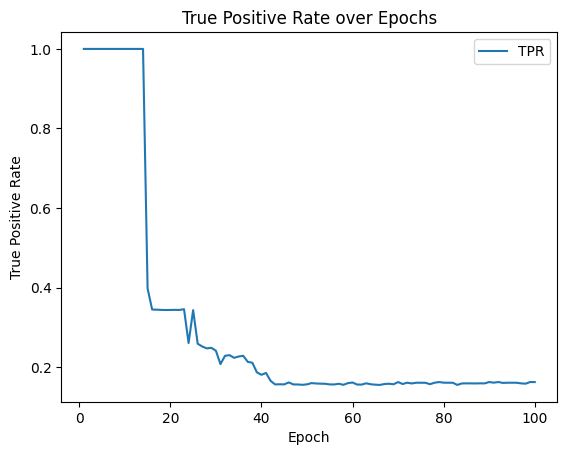

In [ ]:
plt.plot(range(1, num_epoch + 1), tpr_values, label='TPR')
plt.xlabel('Epoch')
plt.ylabel('True Positive Rate')
plt.title('True Positive Rate over Epochs')
plt.legend()
plt.show()

In [ ]:
TensorOrFloat = Union[torch.Tensor, float]
TorchOrNumpy = Union[torch.Tensor, np.ndarray]

In [ ]:
def _export_results(valid_loss: TensorOrFloat, test_loss: TensorOrFloat, avg_num_bits_changed: TensorOrFloat, y_actual: np.ndarray, y_mal_orig: TorchOrNumpy, y_prob: TorchOrNumpy, y_hat: np.ndarray, cyc_len: int):
    if isinstance(y_prob, torch.Tensor):
        y_prob = y_prob.cpu().numpy()
    if isinstance(y_mal_orig, torch.Tensor):
        y_mal_orig = y_mal_orig.cpu().numpy()

    results_file = Path("results_with_epochs.csv")
    exists = results_file.exists()
    with open(str(results_file), "a+") as f_out:
        header = ",".join(["time_completed,M,Z,batch_size,Number of Epochs,test_set_size,detector_type,activation",
                           "gen_hidden_dim,discim_hidden_dim",
                           "avg_validation_loss,avg_test_loss,avg_num_bits_changed",
                           "auc,orig_mal_detect_rate,mod_mal_detect_rate,ben_mal_detect_rate",])
        if not exists:
            f_out.write(header)

        results = ["\n%s" % datetime.datetime.now(),
                   "%d,%d,%d,%d" % (malware.num_features, Z, MALWARE_BATCH_SIZE, cyc_len),
                   "%d,%s,%s" % (len(y_actual), bb.type, g.__class__.__name__),
                   "\"%s\",\"%s\"" % (str(gen), str(discrim)),
                   "%.15f,%.15f,%.3f" % (valid_loss, test_loss, avg_num_bits_changed)]

        auc = roc_auc_score(y_actual, y_prob)
        results.append("%.8f" % auc)

        # Calculate the detection rate on unmodified malware
        results.append("%.8f" % y_mal_orig.mean())
        tn, fp, fn, tp = confusion_matrix(y_actual, y_hat).ravel()
        tpr, fpr = tp / (tp + fn), fp / (tn + fp)
        for rate in [tpr, fpr]:
            results.append("%.8f" % rate)
        results = ",".join(results)
        f_out.write(results)

        return "".join([header, results]),tpr,fpr

In [ ]:
def measure_and_export_results(cyc_len: int, adversarial_feature_vector_directory: str, output_filename: str,gen,discrim) -> str:
  r"""
  Measure the test accuracy and provide results information
  :param cyc_len: Number of cycles (epochs) to train the model.
  :return: Results information as a comma separated string
  """
  if not os.path.exists(adversarial_feature_vector_directory):
      os.mkdir(adversarial_feature_vector_directory)
  valid_loss = _meas_loader_gen_loss(mal_data.valid,gen,discrim)
  test_loss = _meas_loader_gen_loss(mal_data.test,gen,discrim)
  print(f"[+] Final Validation Loss: {valid_loss}")
  print(f"[+] Final Test Loss: {test_loss}")
  num_mal_test = 0
  y_mal_orig, m_prime_arr, bits_changed = [], [], []
  for m, _ in mal_data.test:
      y_mal_orig.append(bb.predict(m.cpu()))
      m = m.to(device)
      num_mal_test += m.shape[0]
      m_prime, _ = gen.forward(m)
      m_prime = m_prime.to(device)
      m_prime_arr.append(m_prime)
      m_diff = m_prime - m
      bits_changed.append(torch.sum(m_diff.cpu(), dim=1))
      msg = "Malware signature changed to 0 which is not allowed"
      assert torch.sum(m_diff < -0.1) == 0, msg
  avg_changed_bits = torch.cat(bits_changed).mean()

  pickle.dump(m_prime_arr, open(os.path.join(adversarial_feature_vector_directory, output_filename), 'wb'))
  print(f"[+] Avg. Malware Bits Changed Changed: {avg_changed_bits}")
  # BB prediction of the malware before the generator
  y_mal_orig = torch.cat(y_mal_orig).to(device)
  # Build an X tensor for prediction using the detector
  ben_test_arr = [x.to(device) for x, _ in ben_data.test]
  x = torch.cat(m_prime_arr + ben_test_arr).to(device)
  y_actual = torch.cat((torch.full((num_mal_test,), 1), torch.full((len(x) - num_mal_test,), 0)))
  # y_hat_post = bb.predict(x)
  # print(y_hat_post)
  y_hat_post = (discrim.forward(x) < 0.5).float()
  # print(y_hat_post)
  y_actual = y_actual.float().to(device)
  y_hat_post = y_hat_post.to(device)
  print(torch.equal(y_actual.float(),y_hat_post))
  # if self._is_cuda:
  #     y_mal_orig, y_hat_post, y_actual = y_mal_orig.cpu(), y_hat_post.cpu(), y_actual.cpu()
  y_prob = bb._model.predict_proba(x.cpu())
  y_prob = y_prob[:, 1]
  return _export_results(valid_loss, test_loss, avg_changed_bits, y_actual, y_mal_orig, y_prob, y_hat_post, cyc_len)

In [ ]:
results , tpr, fpr = measure_and_export_results(num_epoch, str('/content/drive/MyDrive/Output'), 'adversarial_feature_set.pk',gen,discrim)
# results
tpr, fpr

[+] Final Validation Loss: 1.1920930376163597e-07
[+] Final Test Loss: 1.1920930376163597e-07
[+] Avg. Malware Bits Changed Changed: 140.36697387695312
False


(0.0, 0.9287489643744822)

In [ ]:
import numpy as np

with open('/content/drive/MyDrive/Output/adversarial_feature_set.pk','rb') as f:
  data = pickle.load(f)

data[0]

tensor([[1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [ ]:
data[0][0]

tensor([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 

In [ ]:
len(data[0][0])

317

In [ ]:
# train model
## schedules copied from https://huggingface.co/blog/annotated-diffusion

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.25
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

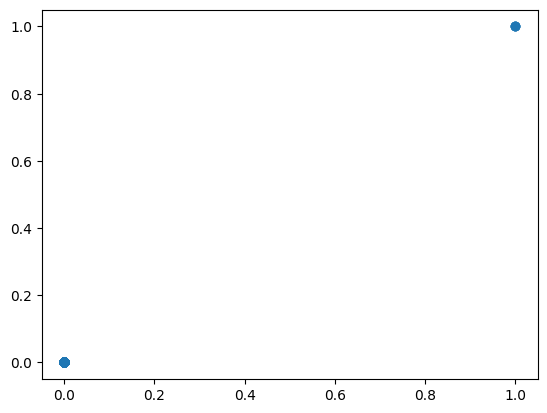

In [ ]:
# Train model
timesteps = 1000
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = torch.sqrt(variance)

import torch.nn.functional as F

alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)
alphas_ = alphas_.to(device)
sd = sd.to(device)
# how to add noise of the data
def get_noisy(batch, timestep):
    batch = batch.to(device)
    if not batch.requires_grad:
        batch.requires_grad_(True)
    added_noise_at_t = torch.normal(batch*torch.sqrt(alphas_[timestep]).to(device), std=sd[timestep]).to(device)
    # added_noise_at_t_positive = torch.abs(added_noise_at_t).to(device)
    added_noise_at_t_binarized = (added_noise_at_t > 0.5).float().to(device)

    return added_noise_at_t_binarized

# def reverse_noisy(batch_pred, timestep):

added_noise_at_t = get_noisy(merge_data, 5).cpu()
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (1 - alphas) * (1 - alphas_prev_) / (1 - alphas)

In [ ]:
added_noise_at_t.shape

torch.Size([5960, 317])

In [ ]:
merge_data[0]

tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
# model = DenoisingModel(malware.num_features,482,malware.num_features).to(device)

In [ ]:
# loss_func = nn.HuberLoss()

In [ ]:
malware.num_features

317

In [ ]:
# batch_size = min(len(mal_data.train), len(ben_data.train))

In [ ]:
#%% Diffusion coefficients
def var_func_vp(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    var = 1. - torch.exp(2. * log_mean_coeff)
    return var

def var_func_geometric(t, beta_min, beta_max):
    return beta_min * ((beta_max / beta_min) ** t)

def extract(input, t, shape):
    out = torch.gather(input, 0, t)
    reshape = [shape[0]] + [1] * (len(shape) - 1)
    out = out.reshape(*reshape)

    return out

def get_time_schedule(args, device):
    n_timestep = args.num_timesteps
    eps_small = 1e-3
    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small)  + eps_small
    return t.to(device)

def get_sigma_schedule(args, device):
    n_timestep = args.num_timesteps
    beta_min = args.beta_min
    beta_max = args.beta_max
    eps_small = 1e-3

    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small) + eps_small

    if args.use_geometric:
        var = var_func_geometric(t, beta_min, beta_max)
    else:
        var = var_func_vp(t, beta_min, beta_max)
    alpha_bars = 1.0 - var
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]

    first = torch.tensor(1e-8)
    betas = torch.cat((first[None], betas)).to(device)
    betas = betas.type(torch.float32)
    sigmas = betas**0.5
    a_s = torch.sqrt(1-betas)
    return sigmas, a_s, betas

class Diffusion_Coefficients():
    def __init__(self, args, device):

        self.sigmas, self.a_s, _ = get_sigma_schedule(args, device=device)
        self.a_s_cum = np.cumprod(self.a_s.cpu())
        self.sigmas_cum = np.sqrt(1 - self.a_s_cum ** 2)
        self.a_s_prev = self.a_s.clone()
        self.a_s_prev[-1] = 1

        self.a_s_cum = self.a_s_cum.to(device)
        self.sigmas_cum = self.sigmas_cum.to(device)
        self.a_s_prev = self.a_s_prev.to(device)

def q_sample(coeff, x_start, t, *, noise=None):
    """
    Diffuse the data (t == 0 means diffused for t step)
    """
    if noise is None:
      noise = torch.randn_like(x_start)

    x_t = extract(coeff.a_s_cum, t, x_start.shape) * x_start + extract(coeff.sigmas_cum, t, x_start.shape) * noise

    return x_t

def q_sample_pairs(coeff, x_start, t):
    """
    Generate a pair of disturbed images for training
    :param x_start: x_0
    :param t: time step t
    :return: x_t, x_{t+1}
    """
    noise = torch.randn_like(x_start)
    x_t = q_sample(coeff, x_start, t)
    x_t_plus_one = extract(coeff.a_s, t+1, x_start.shape) * x_t + extract(coeff.sigmas, t+1, x_start.shape) * noise

    return x_t, x_t_plus_one
#%% posterior sampling
class Posterior_Coefficients():
    def __init__(self, args, device):

        _, _, self.betas = get_sigma_schedule(args, device=device)

        #we don't need the zeros
        self.betas = self.betas.type(torch.float32)[1:]

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, 0)
        self.alphas_cumprod_prev = torch.cat(
                                    (torch.tensor([1.], dtype=torch.float32,device=device), self.alphas_cumprod[:-1]), 0
                                        )
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.rsqrt(self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod - 1)

        self.posterior_mean_coef1 = (self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1 - self.alphas_cumprod))
        self.posterior_mean_coef2 = ((1 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1 - self.alphas_cumprod))

        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))

def sample_posterior(coefficients, x_0,x_t, t):

    def q_posterior(x_0, x_t, t):
        mean = (
            extract(coefficients.posterior_mean_coef1, t, x_t.shape) * x_0
            + extract(coefficients.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        var = extract(coefficients.posterior_variance, t, x_t.shape)
        log_var_clipped = extract(coefficients.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var_clipped


    def p_sample(x_0, x_t, t):
        mean, _, log_var = q_posterior(x_0, x_t, t)

        noise = torch.randn_like(x_t)

        nonzero_mask = (1 - (t == 0).type(torch.float32))

        return mean + nonzero_mask[:,None,None,None] * torch.exp(0.5 * log_var) * noise

    sample_x_pos = p_sample(x_0, x_t, t)

    return sample_x_pos

def sample_from_model(coefficients, generator, n_time, x_init, T, opt):
    x = x_init
    with torch.no_grad():
        for i in reversed(range(n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)

            t_time = t
            latent_z = torch.randn(x.size(0), opt.nz, device=x.device)
            x_0 = generator(x, t_time, latent_z)
            x_new = sample_posterior(coefficients, x_0, x, t)
            x = x_new.detach()

    return x

In [ ]:
class Args:
    def __init__(self, num_timesteps, beta_min, beta_max, use_geometric):
        self.num_timesteps = num_timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.use_geometric = use_geometric

args = Args(num_timesteps=100, beta_min=0.0001, beta_max=0.25,use_geometric = False)


In [ ]:
coeff = Diffusion_Coefficients(args, device)
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)

In [ ]:
diff_gen = Generator(M=malware.num_features, Z=10, hidden_size=[241,482,241], g=g).to(device)

In [ ]:
diff_discrim = Discriminator(M=malware.num_features, hidden_size=[241,482,482,241], g=g).to(device)

In [ ]:
diff_d_optimizer = torch.optim.Adam(diff_discrim.parameters(), lr=1e-5)
diff_g_optimizer = torch.optim.Adam(diff_gen.parameters(), lr=1e-4)

In [ ]:
epochs = 100

In [ ]:
schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(diff_g_optimizer, epochs, eta_min=1e-5)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(diff_d_optimizer, epochs, eta_min=1e-5)

In [ ]:
t = torch.randint(0, args.num_timesteps, (MALWARE_BATCH_SIZE,), device=device)
t

tensor([94,  9, 53, 22,  5, 54, 48, 58, 18, 41, 32, 55, 41, 50, 82, 28, 42, 77,
        92, 40, 95, 35, 26, 70,  5, 18, 65, 88, 30, 42, 46, 33])

In [ ]:
for a,b in mal_data.train:
  c = a
  break
c

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
c.size(0)

32

In [ ]:
x_t,x_tp1 = q_sample_pairs(coeff,c,t)

In [ ]:
x_t,x_tp1

(tensor([[ 0.9103, -0.1564,  1.4121,  ..., -0.1709, -0.1046,  0.6406],
         [ 0.9980,  1.0336,  0.9654,  ...,  0.0233,  0.0195,  0.0278],
         [ 1.1236,  0.8124,  0.9896,  ...,  0.2572, -0.3212, -0.0719],
         ...,
         [ 1.0734,  0.9894,  1.0565,  ..., -0.1461,  0.1516,  0.0861],
         [ 0.8563,  1.0175,  0.9740,  ...,  0.1670, -0.2206,  0.1241],
         [ 1.0974,  0.9519,  1.0203,  ...,  0.3295, -0.1568,  0.1115]]),
 tensor([[ 0.9725, -0.1707,  1.3612,  ..., -0.1918, -0.0937,  0.6570],
         [ 1.0104,  1.0372,  0.9714,  ...,  0.0345, -0.0064,  0.0180],
         [ 1.0806,  0.8043,  0.9783,  ...,  0.2138, -0.3610, -0.0736],
         ...,
         [ 1.0663,  1.0223,  1.0805,  ..., -0.2096,  0.1213,  0.0362],
         [ 0.8700,  1.0727,  0.9672,  ...,  0.1846, -0.2635,  0.0964],
         [ 1.1060,  0.9166,  0.9667,  ...,  0.3124, -0.1864,  0.1320]]))

In [ ]:
def _fit_epoch_diff(epoch_num: int, g_optim: torch.optim.Optimizer, d_optim: torch.optim.Optimizer) -> TensorTuple:
        """
        Trains a single entire epoch

        :param epoch_num: Epoch number
        :param g_optim: Generator optimizer
        :param d_optim: Discriminator optimizer
        :return: Average training loss
        """
        tot_l_g = tot_l_d = 0
        num_batch = min(len(mal_data.train), len(ben_data.train))

        print(f"Starting training epoch #{epoch_num} with {num_batch} batches")
        desc = f"Epoch {epoch_num} Progress"
        batch_generator = merged_data = zip(mal_data.train, ben_data.train)
        for (m, _), (b, _) in batch_generator:
            if torch.cuda.is_available():
                m, b = m.to(device), b.to(device)
            #sample t
            t = torch.randint(0, args.num_timesteps, (m.size(0),), device=device)
            x_t, x_tp1 = q_sample_pairs(coeff, m, t)
            # x_t.requires_grad = True
            for x in [x_t,b]:
              d_tetha = diff_discrim.forward(x)
              l_d = -(torch.where(bb.predict(x) == 1, d_tetha, 1 - d_tetha)).log().mean()
              d_optim.zero_grad()
              l_d.backward()
              d_optim.step()
              tot_l_d += l_d


            m_prime, g_theta = diff_gen.forward(x_tp1)
            m_pos_sample = sample_posterior(pos_coeff, g_theta, x_tp1, t)
            l_g = -diff_discrim.forward(m_pos_sample).log().mean()
            g_optim.zero_grad()
            l_g.backward()
            # torch.nn.utils.clip_grad_value_(l_g, 1)
            g_optim.step()
            tot_l_g += l_g

            # Update the discriminator
            for x in [m_prime, b]:
                x = x.to(device)
                d_tetha = diff_discrim.forward(x)
                l_d = -(torch.where(bb.predict(x) == 1, d_tetha, 1 - d_tetha)).log().mean()
                d_optim.zero_grad()
                l_d.backward()
                # torch.nn.utils.clip_grad_value_(l_d, 1)
                d_optim.step()
                tot_l_d += l_d
        print(f"\t Completed training epoch #{epoch_num}")
        return tot_l_g / num_batch, tot_l_d / num_batch

In [ ]:
tpr_values_diff= []

In [ ]:
for epoch_cnt in track(range(1, epochs + 1), description="Training GAN ...", transient=True):
    train_l_g, train_l_d = _fit_epoch_diff(epoch_cnt,diff_g_optimizer, diff_d_optimizer)
    for block, loss in [("Generator", train_l_g), ("Discriminator", train_l_d)]:
        tensorboard.add_scalar('Train_%s_Loss' % block, loss, epoch_cnt)
        print(f"\t Epoch {epoch_cnt}: Avg Train {block} Loss: {loss}")
    valid_l_g= _meas_loader_gen_loss(mal_data.valid,diff_gen,diff_discrim)
    tpr_values_diff.append(_calculate_tpr_for_epoch(mal_data.train, bb, diff_discrim))
    tensorboard.add_scalar('Validation_Generator_Loss', valid_l_g, epoch_cnt)
    if valid_l_g < best_loss:
        # _save(self._build_export_name(epoch_cnt))
        # if best_epoch is not None:
        #     self._delete_old_backup(best_epoch)
        best_epoch, best_loss = epoch_cnt, valid_l_g
        print(f"\t Epoch {best_epoch}: New best validation loss: {best_loss}\n")
    else:
        print(f"\t Epoch {epoch_cnt}: Avg Validation Generator Loss: {valid_l_g}\n")
print(f" Training complete. Best epoch is {best_epoch} with loss {best_loss}")
tensorboard.close()

Output()

Starting training epoch #1 with 99 batches

Completed training epoch #1

Epoch 1: Avg Train Generator Loss: 0.7115336060523987

Epoch 1: Avg Train Discriminator Loss: 2.737152099609375

TPR for Training set: 1.0

Epoch 1: Avg Validation Generator Loss: 0.6704853773117065

Starting training epoch #2 with 99 batches

Completed training epoch #2

Epoch 2: Avg Train Generator Loss: 0.6545983552932739

Epoch 2: Avg Train Discriminator Loss: 2.308258295059204

TPR for Training set: 0.8920814326056262

Epoch 2: Avg Validation Generator Loss: 0.05102565139532089

Starting training epoch #3 with 99 batches

Completed training epoch #3

Epoch 3: Avg Train Generator Loss: 0.46051424741744995

Epoch 3: Avg Train Discriminator Loss: 1.5712083578109741

TPR for Training set: 0.2758451449983708

Epoch 3: Avg Validation Generator Loss: 0.0019452439155429602

Starting training epoch #4 with 99 batches

Completed training epoch #4

Epoch 4: Avg Train Generator Loss: 0.27862748503685

Epoch 4: Avg Train Discriminator Loss: 1.1139639616012573

TPR for Training set: 0.2323795753231237

Epoch 4: Avg Validation Generator Loss: 0.00013635391951538622

Starting training epoch #5 with 99 batches

Completed training epoch #5

Epoch 5: Avg Train Generator Loss: 0.16718851029872894

Epoch 5: Avg Train Discriminator Loss: 0.8382793664932251

TPR for Training set: 0.09513713329063718

Epoch 5: Avg Validation Generator Loss: 1.658912151469849e-05

Starting training epoch #6 with 99 batches

Completed training epoch #6

Epoch 6: Avg Train Generator Loss: 0.11542556434869766

Epoch 6: Avg Train Discriminator Loss: 0.7021496891975403

TPR for Training set: 0.09387626262626261

Epoch 6: Avg Validation Generator Loss: 2.995538125105668e-06

Starting training epoch #7 with 99 batches

Completed training epoch #7

Epoch 7: Avg Train Generator Loss: 0.09265159070491791

Epoch 7: Avg Train Discriminator Loss: 0.6291016340255737

TPR for Training set: 0.02329138155751059

Epoch 7: Avg Validation Generator Loss: 9.686687008070294e-07

Starting training epoch #8 with 99 batches

Completed training epoch #8

Epoch 8: Avg Train Generator Loss: 0.07621478289365768

Epoch 8: Avg Train Discriminator Loss: 0.5719521045684814

TPR for Training set: 0.023807293363744972

Epoch 8: Avg Validation Generator Loss: 4.792586310031766e-07

Starting training epoch #9 with 99 batches

Completed training epoch #9

Epoch 9: Avg Train Generator Loss: 0.07155480235815048

Epoch 9: Avg Train Discriminator Loss: 0.5045285820960999

TPR for Training set: 0.023858205713044426

Epoch 9: Avg Validation Generator Loss: 2.440065429709648e-07

Starting training epoch #10 with 99 batches

Completed training epoch #10

Epoch 10: Avg Train Generator Loss: 0.07450887560844421

Epoch 10: Avg Train Discriminator Loss: 0.5020790696144104

TPR for Training set: 0.02418757935304098

Epoch 10: Avg Validation Generator Loss: 2.386979929269728e-07

Starting training epoch #11 with 99 batches

Completed training epoch #11

Epoch 11: Avg Train Generator Loss: 0.06487388163805008

Epoch 11: Avg Train Discriminator Loss: 0.4676990211009979

TPR for Training set: 0.02780289453676551

Epoch 11: Avg Validation Generator Loss: 2.4074691395981063e-07

Starting training epoch #12 with 99 batches

Completed training epoch #12

Epoch 12: Avg Train Generator Loss: 0.07374979555606842

Epoch 12: Avg Train Discriminator Loss: 0.49657711386680603

TPR for Training set: 0.026804333659172366

Epoch 12: Avg Validation Generator Loss: 6.047077931725653e-07

Starting training epoch #13 with 99 batches

Completed training epoch #13

Epoch 13: Avg Train Generator Loss: 0.06398142874240875

Epoch 13: Avg Train Discriminator Loss: 0.43730688095092773

TPR for Training set: 0.0274173183447377

Epoch 13: Avg Validation Generator Loss: 6.043352414053516e-07

Starting training epoch #14 with 99 batches

Completed training epoch #14

Epoch 14: Avg Train Generator Loss: 0.06550425291061401

Epoch 14: Avg Train Discriminator Loss: 0.4212127923965454

TPR for Training set: 0.02410258498968176

Epoch 14: Avg Validation Generator Loss: 3.060592348447244e-07

Starting training epoch #15 with 99 batches

Completed training epoch #15

Epoch 15: Avg Train Generator Loss: 0.06359786540269852

Epoch 15: Avg Train Discriminator Loss: 0.4536890983581543

TPR for Training set: 0.024774628000434448

Epoch 15: Avg Validation Generator Loss: 1.2710959254036425e-06

Starting training epoch #16 with 99 batches

Completed training epoch #16

Epoch 16: Avg Train Generator Loss: 0.07419098913669586

Epoch 16: Avg Train Discriminator Loss: 0.42453059554100037

TPR for Training set: 0.02251344086021505

Epoch 16: Avg Validation Generator Loss: 1.148667024608585e-06

Starting training epoch #17 with 99 batches

Completed training epoch #17

Epoch 17: Avg Train Generator Loss: 0.07118941098451614

Epoch 17: Avg Train Discriminator Loss: 0.42379432916641235

TPR for Training set: 0.02262959124054786

Epoch 17: Avg Validation Generator Loss: 1.6323032241416513e-06

Starting training epoch #18 with 99 batches

Completed training epoch #18

Epoch 18: Avg Train Generator Loss: 0.0711921900510788

Epoch 18: Avg Train Discriminator Loss: 0.41024357080459595

TPR for Training set: 0.0225453459324427

Epoch 18: Avg Validation Generator Loss: 1.5117900602490408e-06

Starting training epoch #19 with 99 batches

Completed training epoch #19

Epoch 19: Avg Train Generator Loss: 0.07066536694765091

Epoch 19: Avg Train Discriminator Loss: 0.41745322942733765

TPR for Training set: 0.02255620723362659

Epoch 19: Avg Validation Generator Loss: 2.4884297999960836e-06

Starting training epoch #20 with 99 batches

Completed training epoch #20

Epoch 20: Avg Train Generator Loss: 0.07187651842832565

Epoch 20: Avg Train Discriminator Loss: 0.4260038137435913

TPR for Training set: 0.021892310198761807

Epoch 20: Avg Validation Generator Loss: 4.304144113120856e-06

Starting training epoch #21 with 99 batches

Completed training epoch #21

Epoch 21: Avg Train Generator Loss: 0.06834093481302261

Epoch 21: Avg Train Discriminator Loss: 0.41149261593818665

TPR for Training set: 0.0219024926686217

Epoch 21: Avg Validation Generator Loss: 6.283105904003605e-06

Starting training epoch #22 with 99 batches

Completed training epoch #22

Epoch 22: Avg Train Generator Loss: 0.07162293791770935

Epoch 22: Avg Train Discriminator Loss: 0.3761454224586487

TPR for Training set: 0.02094534050179211

Epoch 22: Avg Validation Generator Loss: 6.206643774930853e-06

Starting training epoch #23 with 99 batches

Completed training epoch #23

Epoch 23: Avg Train Generator Loss: 0.06715227663516998

Epoch 23: Avg Train Discriminator Loss: 0.37749814987182617

TPR for Training set: 0.02367967307483437

Epoch 23: Avg Validation Generator Loss: 1.1247563634242397e-05

Starting training epoch #24 with 99 batches

Completed training epoch #24

Epoch 24: Avg Train Generator Loss: 0.07512473315000534

Epoch 24: Avg Train Discriminator Loss: 0.3762139081954956

TPR for Training set: 0.021016617790811338

Epoch 24: Avg Validation Generator Loss: 1.2596194210345857e-05

Starting training epoch #25 with 99 batches

Completed training epoch #25

Epoch 25: Avg Train Generator Loss: 0.07413361966609955

Epoch 25: Avg Train Discriminator Loss: 0.3656666576862335

TPR for Training set: 0.0219024926686217

Epoch 25: Avg Validation Generator Loss: 3.0186274670995772e-05

Starting training epoch #26 with 99 batches

Completed training epoch #26

Epoch 26: Avg Train Generator Loss: 0.0720922127366066

Epoch 26: Avg Train Discriminator Loss: 0.35254719853401184

TPR for Training set: 0.020967063104159876

Epoch 26: Avg Validation Generator Loss: 5.169558426132426e-05

Starting training epoch #27 with 99 batches

Completed training epoch #27

Epoch 27: Avg Train Generator Loss: 0.07012292742729187

Epoch 27: Avg Train Discriminator Loss: 0.32854923605918884

TPR for Training set: 0.02071250135766265

Epoch 27: Avg Validation Generator Loss: 3.168718103552237e-05

Starting training epoch #28 with 99 batches

Completed training epoch #28

Epoch 28: Avg Train Generator Loss: 0.0705566257238388

Epoch 28: Avg Train Discriminator Loss: 0.32247650623321533

TPR for Training set: 0.020639866405995435

Epoch 28: Avg Validation Generator Loss: 2.0012126697110943e-05

Starting training epoch #29 with 99 batches

Completed training epoch #29

Epoch 29: Avg Train Discriminator Loss: 0.3268338739871979

TPR for Training set: 0.02237495927012056

Epoch 29: Avg Validation Generator Loss: 1.4577490219380707e-05

Starting training epoch #30 with 99 batches

Completed training epoch #30

Epoch 30: Avg Train Generator Loss: 0.0693531483411789

Epoch 30: Avg Train Discriminator Loss: 0.31405478715896606

TPR for Training set: 0.020365618551102423

Epoch 30: Avg Validation Generator Loss: 1.549574517412111e-05

Starting training epoch #31 with 99 batches

Completed training epoch #31

Epoch 31: Avg Train Generator Loss: 0.07508911937475204

Epoch 31: Avg Train Discriminator Loss: 0.32869550585746765

TPR for Training set: 0.02033507114152275

Epoch 31: Avg Validation Generator Loss: 0.00017371996364090592

Starting training epoch #32 with 99 batches

Completed training epoch #32

Epoch 32: Avg Train Generator Loss: 0.07939234375953674

Epoch 32: Avg Train Discriminator Loss: 0.30171915888786316

TPR for Training set: 0.020365618551102423

Epoch 32: Avg Validation Generator Loss: 4.533655010163784e-05

Starting training epoch #33 with 99 batches

Completed training epoch #33

Epoch 33: Avg Train Generator Loss: 0.09044858813285828

Epoch 33: Avg Train Discriminator Loss: 0.3395417332649231

TPR for Training set: 0.01717986314760508

Epoch 33: Avg Validation Generator Loss: 0.001905900426208973

Starting training epoch #34 with 99 batches

Completed training epoch #34

Epoch 34: Avg Train Generator Loss: 0.07805167883634567

Epoch 34: Avg Train Discriminator Loss: 0.2868637144565582

TPR for Training set: 0.017462935809710003

Epoch 34: Avg Validation Generator Loss: 0.0004504770040512085

Starting training epoch #35 with 99 batches

Completed training epoch #35

Epoch 35: Avg Train Generator Loss: 0.0773593932390213

Epoch 35: Avg Train Discriminator Loss: 0.28756478428840637

TPR for Training set: 0.017157461713913323

Epoch 35: Avg Validation Generator Loss: 0.00019197360961697996

Starting training epoch #36 with 99 batches

Completed training epoch #36

Epoch 36: Avg Train Generator Loss: 0.08813169598579407

Epoch 36: Avg Train Discriminator Loss: 0.30375078320503235

TPR for Training set: 0.017432388400130335

Epoch 36: Avg Validation Generator Loss: 0.00019835247076116502

Starting training epoch #37 with 99 batches

Completed training epoch #37

Epoch 37: Avg Train Generator Loss: 0.07820889353752136

Epoch 37: Avg Train Discriminator Loss: 0.25032901763916016

TPR for Training set: 0.017137096774193547

Epoch 37: Avg Validation Generator Loss: 3.950612517655827e-05

Starting training epoch #38 with 99 batches

Completed training epoch #38

Epoch 38: Avg Train Generator Loss: 0.07104571908712387

Epoch 38: Avg Train Discriminator Loss: 0.26057955622673035

TPR for Training set: 0.014571114369501465

Epoch 38: Avg Validation Generator Loss: 3.425584509386681e-05

Starting training epoch #39 with 99 batches

Completed training epoch #39

Epoch 39: Avg Train Generator Loss: 0.08109474182128906

Epoch 39: Avg Train Discriminator Loss: 0.28190889954566956

TPR for Training set: 0.014612523080265017

Epoch 39: Avg Validation Generator Loss: 0.0001394614955643192

Starting training epoch #40 with 99 batches

Completed training epoch #40

Epoch 40: Avg Train Generator Loss: 0.08241662383079529

Epoch 40: Avg Train Discriminator Loss: 0.24880990386009216

TPR for Training set: 0.013980531117627891

Epoch 40: Avg Validation Generator Loss: 2.7279966161586344e-05

Starting training epoch #41 with 99 batches

Completed training epoch #41

Epoch 41: Avg Train Generator Loss: 0.0744900107383728

Epoch 41: Avg Train Discriminator Loss: 0.23876474797725677

TPR for Training set: 0.014602340610405126

Epoch 41: Avg Validation Generator Loss: 5.332630826160312e-05

Starting training epoch #42 with 99 batches

Completed training epoch #42

Epoch 42: Avg Train Generator Loss: 0.07948662340641022

Epoch 42: Avg Train Discriminator Loss: 0.2543256878852844

TPR for Training set: 0.014632888019984795

Epoch 42: Avg Validation Generator Loss: 6.127371307229623e-05

Starting training epoch #43 with 99 batches

Completed training epoch #43

Epoch 43: Avg Train Generator Loss: 0.0796351209282875

Epoch 43: Avg Train Discriminator Loss: 0.24262495338916779

TPR for Training set: 0.013971027479091994

Epoch 43: Avg Validation Generator Loss: 2.4407740056631155e-05

Starting training epoch #44 with 99 batches

Completed training epoch #44

Epoch 44: Avg Train Generator Loss: 0.08011937886476517

Epoch 44: Avg Train Discriminator Loss: 0.2489665001630783

TPR for Training set: 0.014022618659715434

Epoch 44: Avg Validation Generator Loss: 0.00018039766291622072

Starting training epoch #45 with 99 batches

Completed training epoch #45

Epoch 45: Avg Train Generator Loss: 0.07670704275369644

Epoch 45: Avg Train Discriminator Loss: 0.23988096415996552

TPR for Training set: 0.014003002775249717

Epoch 45: Avg Validation Generator Loss: 0.00011684221681207418

Starting training epoch #46 with 99 batches

Completed training epoch #46

Epoch 46: Avg Train Generator Loss: 0.08830463886260986

Epoch 46: Avg Train Discriminator Loss: 0.2374163419008255

TPR for Training set: 0.013929618768328444

Epoch 46: Avg Validation Generator Loss: 4.119761069887318e-05

Starting training epoch #47 with 99 batches

Completed training epoch #47

Epoch 47: Avg Train Generator Loss: 0.07709763944149017

Epoch 47: Avg Train Discriminator Loss: 0.24336224794387817

TPR for Training set: 0.013980531117627891

Epoch 47: Avg Validation Generator Loss: 0.00023254207917489111

Starting training epoch #48 with 99 batches

Completed training epoch #48

Epoch 48: Avg Train Generator Loss: 0.0873953104019165

Epoch 48: Avg Train Discriminator Loss: 0.24275793135166168

TPR for Training set: 0.013939801238188334

Epoch 48: Avg Validation Generator Loss: 0.0002550837234593928

Starting training epoch #49 with 99 batches

Completed training epoch #49

Epoch 49: Avg Train Generator Loss: 0.08819665014743805

Epoch 49: Avg Train Discriminator Loss: 0.24943608045578003

TPR for Training set: 0.013991392418811775

Epoch 49: Avg Validation Generator Loss: 0.0015041716396808624

Starting training epoch #50 with 99 batches

Completed training epoch #50

Epoch 50: Avg Train Generator Loss: 0.094692662358284

Epoch 50: Avg Train Discriminator Loss: 0.2484661042690277

TPR for Training set: 0.010865374171825785

Epoch 50: Avg Validation Generator Loss: 0.0001500102662248537

Starting training epoch #51 with 99 batches

Completed training epoch #51

Epoch 51: Avg Train Generator Loss: 0.09012214839458466

Epoch 51: Avg Train Discriminator Loss: 0.2461744099855423

TPR for Training set: 0.0031667481264255454

Epoch 51: Avg Validation Generator Loss: 0.00015864570741541684

Starting training epoch #52 with 99 batches

Completed training epoch #52

Epoch 52: Avg Train Generator Loss: 0.07904662191867828

Epoch 52: Avg Train Discriminator Loss: 0.21750251948833466

TPR for Training set: 0.011424731182795697

Epoch 52: Avg Validation Generator Loss: 0.00011934123176615685

Starting training epoch #53 with 99 batches

Completed training epoch #53

Epoch 53: Avg Train Generator Loss: 0.08542454987764359

Epoch 53: Avg Train Discriminator Loss: 0.2408229559659958

TPR for Training set: 0.0107628706419029

Epoch 53: Avg Validation Generator Loss: 0.0001765626948326826

Starting training epoch #54 with 99 batches

Completed training epoch #54

Epoch 54: Avg Train Generator Loss: 0.08770247548818588

Epoch 54: Avg Train Discriminator Loss: 0.23223260045051575

TPR for Training set: 0.01139418377321603

Epoch 54: Avg Validation Generator Loss: 0.00011770041601266712

Starting training epoch #55 with 99 batches

Completed training epoch #55

Epoch 55: Avg Train Generator Loss: 0.08376982063055038

Epoch 55: Avg Train Discriminator Loss: 0.2304043024778366

TPR for Training set: 0.003197974367329206

Epoch 55: Avg Validation Generator Loss: 8.87134374352172e-05

Starting training epoch #56 with 99 batches

Completed training epoch #56

Epoch 56: Avg Train Generator Loss: 0.08352921903133392

Epoch 56: Avg Train Discriminator Loss: 0.21677462756633759

TPR for Training set: 0.0031871130661453246

Epoch 56: Avg Validation Generator Loss: 7.545923290308565e-05

Starting training epoch #57 with 99 batches

Completed training epoch #57

Epoch 57: Avg Train Generator Loss: 0.07594934850931168

Epoch 57: Avg Train Discriminator Loss: 0.2065366506576538

TPR for Training set: 0.0031667481264255454

Epoch 57: Avg Validation Generator Loss: 4.768168582813814e-05

Starting training epoch #58 with 99 batches

Completed training epoch #58

Epoch 58: Avg Train Generator Loss: 0.08154552429914474

Epoch 58: Avg Train Discriminator Loss: 0.2133275419473648

TPR for Training set: 0.0031769305962854348

Epoch 58: Avg Validation Generator Loss: 3.679460132843815e-05

Starting training epoch #59 with 99 batches

Completed training epoch #59

Epoch 59: Avg Train Generator Loss: 0.08546606451272964

Epoch 59: Avg Train Discriminator Loss: 0.22909921407699585

TPR for Training set: 0.0028823178016726403

Epoch 59: Avg Validation Generator Loss: 0.0002331677096663043

Starting training epoch #60 with 99 batches

Completed training epoch #60

Epoch 60: Avg Train Generator Loss: 0.08140150457620621

Epoch 60: Avg Train Discriminator Loss: 0.2155129611492157

TPR for Training set: 0.0031769305962854348

Epoch 60: Avg Validation Generator Loss: 0.00020630276412703097

Starting training epoch #61 with 99 batches

Completed training epoch #61

Epoch 61: Avg Train Generator Loss: 0.08543137460947037

Epoch 61: Avg Train Discriminator Loss: 0.21828044950962067

TPR for Training set: 0.00285109156076898

Epoch 61: Avg Validation Generator Loss: 3.5405202652327716e-05

Starting training epoch #62 with 99 batches

Completed training epoch #62

Epoch 62: Avg Train Generator Loss: 0.07996581494808197

Epoch 62: Avg Train Discriminator Loss: 0.21948853135108948

TPR for Training set: 0.002219778429455849

Epoch 62: Avg Validation Generator Loss: 0.00010505506361369044

Starting training epoch #63 with 99 batches

Completed training epoch #63

Epoch 63: Avg Train Generator Loss: 0.07836878299713135

Epoch 63: Avg Train Discriminator Loss: 0.21035568416118622

TPR for Training set: 0.002219778429455849

Epoch 63: Avg Validation Generator Loss: 6.659056816715747e-05

Starting training epoch #64 with 99 batches

Completed training epoch #64

Epoch 64: Avg Train Generator Loss: 0.07914180308580399

Epoch 64: Avg Train Discriminator Loss: 0.21906089782714844

TPR for Training set: 0.002219778429455849

Epoch 64: Avg Validation Generator Loss: 4.677542528952472e-05

Starting training epoch #65 with 99 batches

Completed training epoch #65

Epoch 65: Avg Train Generator Loss: 0.07762856036424637

Epoch 65: Avg Train Discriminator Loss: 0.21327246725559235

TPR for Training set: 0.002219778429455849

Epoch 65: Avg Validation Generator Loss: 9.048197534866631e-05

Starting training epoch #66 with 99 batches

Completed training epoch #66

Epoch 66: Avg Train Generator Loss: 0.08743894100189209

Epoch 66: Avg Train Discriminator Loss: 0.2286847084760666

TPR for Training set: 0.0019143043336591723

Epoch 66: Avg Validation Generator Loss: 4.641984560294077e-05

Starting training epoch #67 with 99 batches

Completed training epoch #67

Epoch 67: Avg Train Generator Loss: 0.07811988890171051

Epoch 67: Avg Train Discriminator Loss: 0.21386361122131348

TPR for Training set: 0.0019143043336591723

Epoch 67: Avg Validation Generator Loss: 3.08874950860627e-05

Starting training epoch #68 with 99 batches

Completed training epoch #68

Epoch 68: Avg Train Generator Loss: 0.08485540002584457

Epoch 68: Avg Train Discriminator Loss: 0.21989722549915314

TPR for Training set: 0.0022095959595959595

Epoch 68: Avg Validation Generator Loss: 7.085286779329181e-05

Starting training epoch #69 with 99 batches

Completed training epoch #69

Epoch 69: Avg Train Generator Loss: 0.08142472058534622

Epoch 69: Avg Train Discriminator Loss: 0.2099877893924713

TPR for Training set: 0.0019041218637992831

Epoch 69: Avg Validation Generator Loss: 0.00010048175317933783

Starting training epoch #70 with 99 batches

Completed training epoch #70

Epoch 70: Avg Train Generator Loss: 0.07819467782974243

Epoch 70: Avg Train Discriminator Loss: 0.20416636765003204

TPR for Training set: 0.0019041218637992831

Epoch 70: Avg Validation Generator Loss: 8.817719935905188e-05

Starting training epoch #71 with 99 batches

Completed training epoch #71

Epoch 71: Avg Train Generator Loss: 0.08870755881071091

Epoch 71: Avg Train Discriminator Loss: 0.2175116091966629

TPR for Training set: 0.0019244868035190616

Epoch 71: Avg Validation Generator Loss: 7.777280552545562e-05

Starting training epoch #72 with 99 batches

Completed training epoch #72

Epoch 72: Avg Train Generator Loss: 0.07824373245239258

Epoch 72: Avg Train Discriminator Loss: 0.2110014706850052

TPR for Training set: 0.0019244868035190616

Epoch 72: Avg Validation Generator Loss: 6.0075235523981974e-05

Starting training epoch #73 with 99 batches

Completed training epoch #73

Epoch 73: Avg Train Generator Loss: 0.07703592628240585

Epoch 73: Avg Train Discriminator Loss: 0.20504648983478546

TPR for Training set: 0.0019041218637992831

Epoch 73: Avg Validation Generator Loss: 0.00017484587442595512

Starting training epoch #74 with 99 batches

Completed training epoch #74

Epoch 74: Avg Train Generator Loss: 0.08160163462162018

Epoch 74: Avg Train Discriminator Loss: 0.21475401520729065

TPR for Training set: 0.0019265935214211078

Epoch 74: Avg Validation Generator Loss: 4.528095814748667e-05

Starting training epoch #75 with 99 batches

Completed training epoch #75

Epoch 75: Avg Train Generator Loss: 0.07350432127714157

Epoch 75: Avg Train Discriminator Loss: 0.19569572806358337

TPR for Training set: 0.0019143043336591723

Epoch 75: Avg Validation Generator Loss: 4.531834929366596e-05

Starting training epoch #76 with 99 batches

Completed training epoch #76

Epoch 76: Avg Train Generator Loss: 0.07008027285337448

Epoch 76: Avg Train Discriminator Loss: 0.19692544639110565

TPR for Training set: 0.0019041218637992831

Epoch 76: Avg Validation Generator Loss: 4.9236754421144724e-05

Starting training epoch #77 with 99 batches

Completed training epoch #77

Epoch 77: Avg Train Generator Loss: 0.08292925357818604

Epoch 77: Avg Train Discriminator Loss: 0.2045862227678299

TPR for Training set: 0.0019353481047029433

Epoch 77: Avg Validation Generator Loss: 3.1925323128234595e-05

Starting training epoch #78 with 99 batches

Completed training epoch #78

Epoch 78: Avg Train Generator Loss: 0.07788418233394623

Epoch 78: Avg Train Discriminator Loss: 0.20394036173820496

TPR for Training set: 0.001893939393939394

Epoch 78: Avg Validation Generator Loss: 7.289484346983954e-05

Starting training epoch #79 with 99 batches

Completed training epoch #79

Epoch 79: Avg Train Generator Loss: 0.07551123201847076

Epoch 79: Avg Train Discriminator Loss: 0.19817905128002167

TPR for Training set: 0.0019143043336591723

Epoch 79: Avg Validation Generator Loss: 3.2606789318379015e-05

Starting training epoch #80 with 99 batches

Completed training epoch #80

Epoch 80: Avg Train Generator Loss: 0.07462837547063828

Epoch 80: Avg Train Discriminator Loss: 0.20100347697734833

TPR for Training set: 0.0019041218637992831

Epoch 80: Avg Validation Generator Loss: 5.663163756253198e-05

Starting training epoch #81 with 99 batches

Completed training epoch #81

Epoch 81: Avg Train Generator Loss: 0.08036579936742783

Epoch 81: Avg Train Discriminator Loss: 0.21409107744693756

TPR for Training set: 0.001893939393939394

Epoch 81: Avg Validation Generator Loss: 0.0002032908669207245

Starting training epoch #82 with 99 batches

Completed training epoch #82

Epoch 82: Avg Train Generator Loss: 0.08834134787321091

Epoch 82: Avg Train Discriminator Loss: 0.21173708140850067

TPR for Training set: 0.0019041218637992831

Epoch 82: Avg Validation Generator Loss: 6.168877735035494e-05

Starting training epoch #83 with 99 batches

Completed training epoch #83

Epoch 83: Avg Train Generator Loss: 0.07758349925279617

Epoch 83: Avg Train Discriminator Loss: 0.20002491772174835

TPR for Training set: 0.0019041218637992831

Epoch 83: Avg Validation Generator Loss: 3.2429248676635325e-05

Starting training epoch #84 with 99 batches

Completed training epoch #84

Epoch 84: Avg Train Generator Loss: 0.07255880534648895

Epoch 84: Avg Train Discriminator Loss: 0.19249889254570007

TPR for Training set: 0.0019041218637992831

Epoch 84: Avg Validation Generator Loss: 3.342405761941336e-05

Starting training epoch #85 with 99 batches

Completed training epoch #85

Epoch 85: Avg Train Generator Loss: 0.08653435856103897

Epoch 85: Avg Train Discriminator Loss: 0.2125166654586792

TPR for Training set: 0.0019149831649831648

Epoch 85: Avg Validation Generator Loss: 6.535308057209477e-05

Starting training epoch #86 with 99 batches

Completed training epoch #86

Epoch 86: Avg Train Generator Loss: 0.08721387386322021

Epoch 86: Avg Train Discriminator Loss: 0.21220892667770386

TPR for Training set: 0.0019041218637992831

Epoch 86: Avg Validation Generator Loss: 7.705966709181666e-05

Starting training epoch #87 with 99 batches

Completed training epoch #87

Epoch 87: Avg Train Generator Loss: 0.07926832884550095

Epoch 87: Avg Train Discriminator Loss: 0.18900062143802643

TPR for Training set: 0.0009571521668295861

Epoch 87: Avg Validation Generator Loss: 1.5533678379142657e-05

Starting training epoch #88 with 99 batches

Completed training epoch #88

Epoch 88: Avg Train Generator Loss: 0.08587142080068588

Epoch 88: Avg Train Discriminator Loss: 0.21739470958709717

TPR for Training set: 0.000946969696969697

Epoch 88: Avg Validation Generator Loss: 0.00010463457874720916

Starting training epoch #89 with 99 batches

Completed training epoch #89

Epoch 89: Avg Train Generator Loss: 0.06950584799051285

Epoch 89: Avg Train Discriminator Loss: 0.19729836285114288

TPR for Training set: 0.0009571521668295861

Epoch 89: Avg Validation Generator Loss: 0.0001774897100403905

Starting training epoch #90 with 99 batches

Completed training epoch #90

Epoch 90: Avg Train Generator Loss: 0.08785199373960495

Epoch 90: Avg Train Discriminator Loss: 0.21269918978214264

TPR for Training set: 0.0009571521668295861

Epoch 90: Avg Validation Generator Loss: 3.738891246030107e-05

Starting training epoch #91 with 99 batches

Completed training epoch #91

Epoch 91: Avg Train Generator Loss: 0.07300063222646713

Epoch 91: Avg Train Discriminator Loss: 0.18275536596775055

TPR for Training set: 0.000946969696969697

Epoch 91: Avg Validation Generator Loss: 1.0949506759061478e-05

Starting training epoch #92 with 99 batches

Completed training epoch #92

Epoch 92: Avg Train Generator Loss: 0.08190925419330597

Epoch 92: Avg Train Discriminator Loss: 0.20808102190494537

TPR for Training set: 0.0009673346366894754

Epoch 92: Avg Validation Generator Loss: 4.6667853894177824e-05

Starting training epoch #93 with 99 batches

Completed training epoch #93

Epoch 93: Avg Train Generator Loss: 0.07749255746603012

Epoch 93: Avg Train Discriminator Loss: 0.19355463981628418

TPR for Training set: 0.000946969696969697

Epoch 93: Avg Validation Generator Loss: 5.06060678162612e-05

Starting training epoch #94 with 99 batches

Completed training epoch #94

Epoch 94: Avg Train Generator Loss: 0.0799279734492302

Epoch 94: Avg Train Discriminator Loss: 0.21288742125034332

TPR for Training set: 0.0009571521668295861

Epoch 94: Avg Validation Generator Loss: 4.5979257265571505e-05

Starting training epoch #95 with 99 batches

Completed training epoch #95

Epoch 95: Avg Train Generator Loss: 0.08169194310903549

Epoch 95: Avg Train Discriminator Loss: 0.20463138818740845

TPR for Training set: 0.000946969696969697

Epoch 95: Avg Validation Generator Loss: 2.9641212677233852e-05

Starting training epoch #96 with 99 batches

Completed training epoch #96

Epoch 96: Avg Train Generator Loss: 0.08825108408927917

Epoch 96: Avg Train Discriminator Loss: 0.21950605511665344

TPR for Training set: 0.0009680134680134679

Epoch 96: Avg Validation Generator Loss: 3.243510582251474e-05

Starting training epoch #97 with 99 batches

Completed training epoch #97

Epoch 97: Avg Train Generator Loss: 0.08258682489395142

Epoch 97: Avg Train Discriminator Loss: 0.21263456344604492

TPR for Training set: 0.0009571521668295861

Epoch 97: Avg Validation Generator Loss: 4.26804726885166e-05

Starting training epoch #98 with 99 batches

Completed training epoch #98

Epoch 98: Avg Train Generator Loss: 0.08082504570484161

Epoch 98: Avg Train Discriminator Loss: 0.20957590639591217

TPR for Training set: 0.0009673346366894754

Epoch 98: Avg Validation Generator Loss: 4.8145178880076855e-05

Starting training epoch #99 with 99 batches

Completed training epoch #99

Epoch 99: Avg Train Generator Loss: 0.07858436554670334

Epoch 99: Avg Train Discriminator Loss: 0.19249729812145233

TPR for Training set: 0.0009571521668295861

Epoch 99: Avg Validation Generator Loss: 1.1870547496073414e-05

Starting training epoch #100 with 99 batches

Completed training epoch #100

Epoch 100: Avg Train Generator Loss: 0.07714459300041199

Epoch 100: Avg Train Discriminator Loss: 0.20449455082416534

TPR for Training set: 0.0006313131313131314

Epoch 100: Avg Validation Generator Loss: 2.1582149202004075e-05

 Training complete. Best epoch is 21 with loss 1.1920930376163597e-07


In [ ]:
tpr_values_diff

[1.0,
 0.8920814326056262,
 0.2758451449983708,
 0.2323795753231237,
 0.09513713329063718,
 0.09387626262626261,
 0.02329138155751059,
 0.023807293363744972,
 0.023858205713044426,
 0.02418757935304098,
 0.02780289453676551,
 0.026804333659172366,
 0.0274173183447377,
 0.02410258498968176,
 0.024774628000434448,
 0.02251344086021505,
 0.02262959124054786,
 0.0225453459324427,
 0.02255620723362659,
 0.021892310198761807,
 0.0219024926686217,
 0.02094534050179211,
 0.02367967307483437,
 0.021016617790811338,
 0.0219024926686217,
 0.020967063104159876,
 0.02071250135766265,
 0.020639866405995435,
 0.02237495927012056,
 0.020365618551102423,
 0.02033507114152275,
 0.020365618551102423,
 0.01717986314760508,
 0.017462935809710003,
 0.017157461713913323,
 0.017432388400130335,
 0.017137096774193547,
 0.014571114369501465,
 0.014612523080265017,
 0.013980531117627891,
 0.014602340610405126,
 0.014632888019984795,
 0.013971027479091994,
 0.014022618659715434,
 0.014003002775249717,
 0.01392961

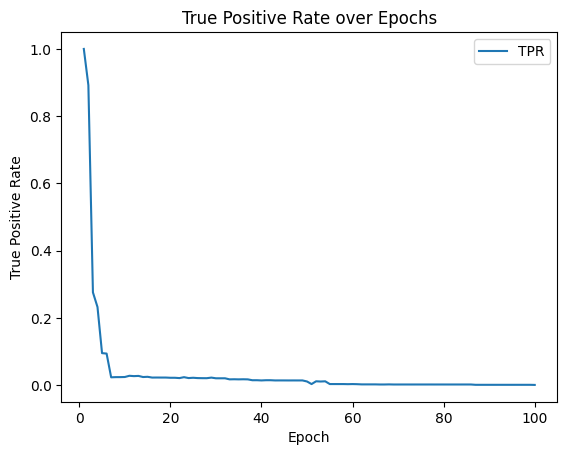

In [ ]:
plt.plot(range(1, num_epoch + 1), tpr_values_diff, label='TPR')
plt.xlabel('Epoch')
plt.ylabel('True Positive Rate')
plt.title('True Positive Rate over Epochs')
plt.legend()
plt.show()

In [ ]:
results , tpr, fpr = measure_and_export_results(num_epoch, str('/content/drive/MyDrive/Output'), 'diff_adversarial_feature_set.pk',diff_gen,diff_discrim)
# results
tpr, fpr

[+] Final Validation Loss: 2.1545532945310697e-05
[+] Final Test Loss: 2.3024003894533962e-05
[+] Avg. Malware Bits Changed Changed: 164.86404418945312
False


(0.0, 0.9246064623032312)

In [ ]:
import numpy as np

with open('/content/drive/MyDrive/Output/diff_adversarial_feature_set.pk','rb') as f:
  data_diff = pickle.load(f)

data_diff[0]

tensor([[1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.]])

In [ ]:
cnt = 0
for a,b in mal_data.train:
  cnt+=1

cnt

99

In [ ]:
len(data_diff), len(data)

(59, 59)

In [ ]:
data_diff[0][0]

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 

In [ ]:
data[0][0]

tensor([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 

In [ ]:
len(data_diff[0][0])

317

In [ ]:
torch.equal(data[0][0], data_diff[0][0])

False

In [ ]:
while True:
  continue